In [1]:
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchinfo import summary

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.io import read_image
from torchvision.io import ImageReadMode
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

plt.style.use('seaborn')
%matplotlib inline

In [2]:
seed = 42
n_channels = 1
n_classes = 5
n_epochs = 10
n_workers = 8
img_size = 28
batch_size = 32
learning_rate = 1e-3
weight_decay = 0.0
device = 'mps'
device = torch.device(device)

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    print('Seed set to', seed)
    
    
set_seed(seed)

Seed set to 42


In [4]:
transform = [
    transforms.ToTensor(),
    transforms.Resize((img_size, img_size)),
    transforms.Pad(2, fill=0),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
]

if n_channels == 1:
    transform.append(transforms.Grayscale())

transform = transforms.Compose(transform)
train_dataset = ImageFolder('./data/train/', transform=transform)
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              num_workers=n_workers,
                              shuffle=True)

In [5]:
class Net(nn.Module):
    
    def __init__(self, n_channels, n_classes):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(n_channels, 6,
                               kernel_size=5,
                               stride=1,
                               padding='valid')
        self.conv2 = nn.Conv2d(6, 16,
                               kernel_size=5,
                               stride=1,
                               padding='valid')
        self.conv3 = nn.Conv2d(16, 120,
                               kernel_size=5,
                               stride=1,
                               padding='valid')
        
        self.avgpool = nn.AvgPool2d(kernel_size=2,
                                    stride=2)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(120, 84)
        self.out = nn.Linear(84, n_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.avgpool(x)
        x = F.relu(self.conv2(x))
        x = self.avgpool(x)
        x = F.relu(self.conv3(x))
        x = self.flatten(x)
        x = F.relu(self.linear1(x))
        output = self.out(x)
        return output


model = Net(n_channels, n_classes)
print(summary(model, input_size=(batch_size, n_channels, 32, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [32, 5]                   --
├─Conv2d: 1-1                            [32, 6, 28, 28]           156
├─AvgPool2d: 1-2                         [32, 6, 14, 14]           --
├─Conv2d: 1-3                            [32, 16, 10, 10]          2,416
├─AvgPool2d: 1-4                         [32, 16, 5, 5]            --
├─Conv2d: 1-5                            [32, 120, 1, 1]           48,120
├─Flatten: 1-6                           [32, 120]                 --
├─Linear: 1-7                            [32, 84]                  10,164
├─Linear: 1-8                            [32, 5]                   425
Total params: 61,281
Trainable params: 61,281
Non-trainable params: 0
Total mult-adds (M): 13.52
Input size (MB): 0.13
Forward/backward pass size (MB): 1.67
Params size (MB): 0.25
Estimated Total Size (MB): 2.04


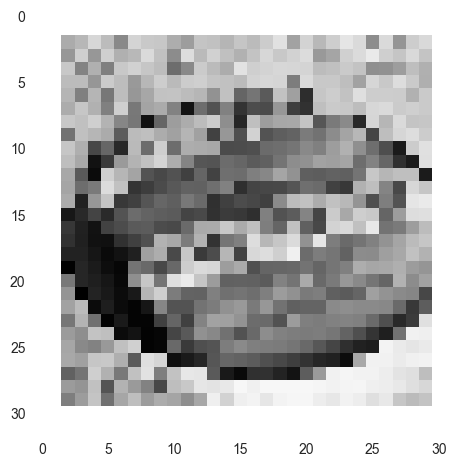

In [24]:
model.to(device)
model.train()

n_iters = 1000
lre = torch.linspace(-1, 0, n_iters)
lrs = 10**lre
lossi = []

data_iter = iter(train_dataloader) 

for i in range(n_iters):
    try:
        data = next(data_iter) 
    except StopIteration:
        data_iter = iter(train_dataloader)
        data = next(data_iter)

    x, y = data
    x, y = x.to(device), y.to(device)
    
    img = x[0].permute(1, 2, 0).cpu()
    img = img * 0.5 + 0.5
    plt.imshow(img)
    plt.grid();
    plt.show();

    pred = model(x)
    loss = F.cross_entropy(pred, y)

    for p in model.parameters():
        p.grad = None
        
    loss.backward()
    
    lr = lrs[i]
    for p in model.parameters():
        p.data += -lr * p.grad
    
    lossi.append(loss.item())
    
    break

In [22]:
plt.plot(lre, F.avg_pool1d(torch.tensor([lossi]), kernel_size=batch_size, stride=1).view(-1,));

RuntimeError: Expected 3D or 4D (batch mode) tensor with optional 0 dim batch size for input, but got:[1, 1, 0]